In [ ]:
#!pip install rasterio

In [1]:
#imports
import os
import rasterio
import glob
from rasterio import plot


In [2]:
# constants
CWD = os.getcwd()
IMG_DIR = '' #'C:\Users\Connor\Desktop\treeDetection\data\image\sentinelSEA\GRANULE\L1C_T10TET_A034087_20211231T191945\IMG_DATA'
OUTPUT_DIR = '/data/processed/'
J_DRIVER = 'JP2OpenJPEG' # driver to process jp2 files
G_DRIVER = 'Gtiff' # driver to process geotiff files
#OUTPUT_NAME = 'test.tif'

FOLDER = 'sentinelSEA' # satellite folder, change to desired satellite data

BAND_COUNT = 3 # used to control the number of bands being written. (rgb default = 3)


In [3]:
# returns the names of necessary files
def get_file_names():
    img_folder = CWD + '/data/image/' + FOLDER + '/GRANULE/'
    IMG_DIR = img_folder + os.listdir(img_folder)[0] + '/IMG_DATA/'
    # need a way to walk through folder and get these manually, will always be in the same place
    #jp2List = os.listdir(IMG_DIR)
    #band_names = [jp2List[1], jp2List[2], jp2List[3]]
    
    band_names = glob.glob(IMG_DIR + '*.jp2')
    
    return band_names, IMG_DIR


In [4]:
# reads downloaded satellite bands (2, 3, 4):(blue, green, red)
def band_process(band_names, IMG_DIR):
    repeat = list(range(1, 4))
    bands = []
    for x in repeat:
        bands.append(rasterio.open(band_names[x], driver = J_DRIVER)) # + IMG_DIR

    return bands


In [5]:
# image processing, writes RGB bands to a singular TIFF file that can be imported to ArcGIS
def band_write(bands):
    trueColor = rasterio.open(CWD + OUTPUT_DIR + 'rgb/' + FOLDER + '_rgb.tif',
                             'w',
                             driver = G_DRIVER,
                             height = bands[0].height,
                             width = bands[0].width,
                             count = BAND_COUNT, # 12
                             crs = bands[0].crs,
                             dtype = bands[0].dtypes[0],
                             transform = bands[0].transform)
    
    desc = BAND_COUNT
    for i in bands:
        trueColor.write(i.read(1), desc)
        desc = desc - 1
        
    trueColor.close()
    

In [6]:
def main():
    band_names, IMG_DIR = get_file_names()
    bands = band_process(band_names, IMG_DIR)
    band_write(bands)
    print("Completed.")
    

In [7]:
main()


Completed.


This section processes the satellite bands using zonal analysis to detect greenspace.

In [56]:
import pandas as pd
import fiona
import numpy as np
import geopandas as gpd
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
np.seterr(invalid='ignore') # ignores nan values in satellite bands


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [9]:
band_names, IMG_DIR = get_file_names()
    
b2 = rasterio.open(band_names[1]) # BLUE
b3 = rasterio.open(band_names[2]) # GREEN
b4 = rasterio.open(band_names[3]) # RED
b8 = rasterio.open(band_names[7]) # NIR
    

In [10]:
def ndvi_calc():
    # (b8 - b4) / (b8 + b4)
    red = b4.read()
    nir = b8.read()

    ndvi = np.zeros(red.shape, dtype = rasterio.float64)
    ndvi = (nir.astype(float) - red.astype(float)) / (nir + red)
    
    return ndvi

TypeError: Image data of dtype object cannot be converted to float

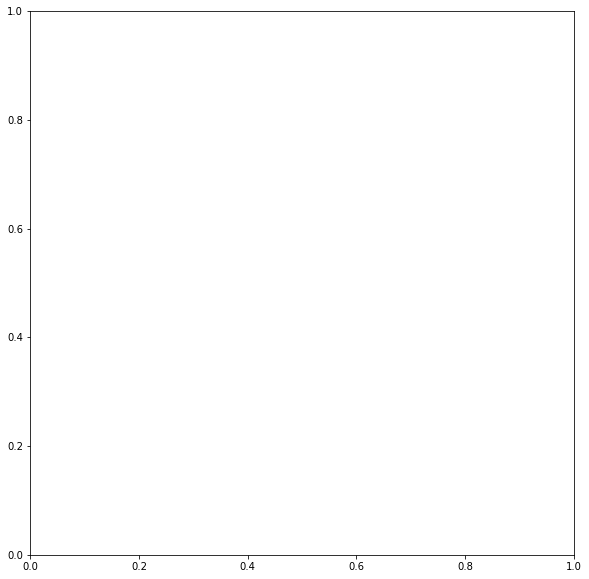

In [26]:
fig, ax = plt.subplots(1, figsize = (12, 10))
show(ndvi, ax = ax, cmap = 'gist_earth')
plt.show()


In [11]:
def ndwi_calc():
    # (b8 - b4) / (b8 + b4)
    green = b3.read()
    nir = b8.read()

    ndwi = np.zeros(green.shape, dtype = rasterio.float64)
    ndwi = (nir.astype(float) - green.astype(float)) / (nir + green)
    
    return ndwi


In [12]:
def export_normalized_diff(data, folder, name):    
    export_loc = CWD + '/data/processed/' + folder + name
    with rasterio.open(export_loc, 'w',
                        driver = G_DRIVER,
                        height = b4.height,
                        width = b4.width,
                        count = 1,  
                        crs = b4.crs,
                        dtype = rasterio.float64,
                        transform = b4.transform) as table:
        table.write(data)
        

In [55]:
def ndvi():
    ndvi = ndvi_calc()
    export_normalized_diff(ndvi, 'ndvi/', FOLDER + '_ndvi.tif')
    print('Mean vegitation density of raster: ' + np.nanmean(ndvi[0]).astype(str))
    print('Completed.')

def ndwi():
    ndwi = ndwi_calc()
    export_normalized_diff(ndwi, 'ndwi/', FOLDER + '_ndwi.tif')
    print('Mean water density of raster: ' + np.nanmean(ndwi[0]).astype(str))
    print('Completed.')
    

In [57]:
ndvi()
ndwi()


Mean vegitation density of raster: 0.09069280073216726
Completed.


AttributeError: 'Rectangle' object has no property 'normed'

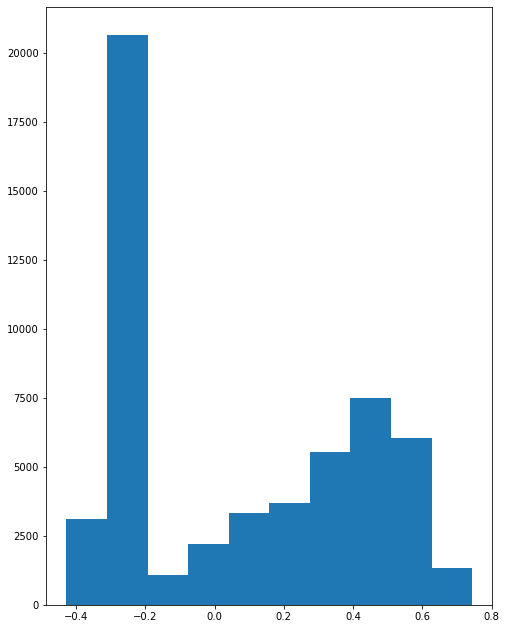

In [44]:
# histogram of values
flat_raster = np.ma.compressed(tif)

fig = plt.figure(figsize=(8,11))
ax = fig.add_subplot(1,1,1)

ax.hist(flat_raster, 10, normed=0, histtype='bar',
    align='mid')